## DBSCAN Implementation From Scratch

In this netbook, we will implement the DBSCAN clustering method from scratch using `numpy`. We will then test it on this [dataset](https://www.kaggle.com/datasets/ankit8467/dataset-for-dbscan/code). We will use `matplotlib` and `seaborn` to visualize the data.

### Installation & Setup

In [3]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn

In [4]:
import os
import pickle

X = pickle.load(open(os.path.join('data', 'dbscan2000.pkl'), 'rb'))

### Data Visualization

In [5]:
X

array([[-2.73226642,  0.11453887],
       [-0.22062047,  0.99308232],
       [ 3.3841416 , -0.95665906],
       ...,
       [ 3.56339167,  0.43936267],
       [-3.59822956,  0.1965186 ],
       [ 4.02733159, -0.19364141]])

In [6]:
len(X)

2000

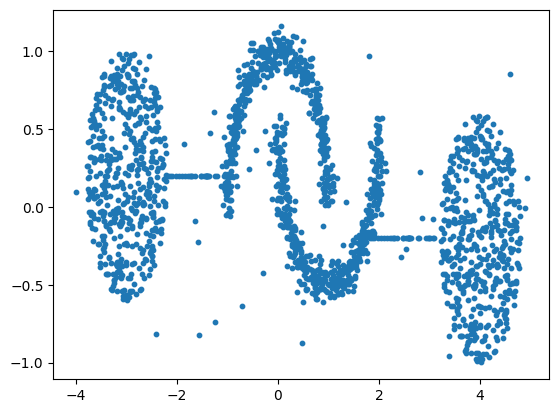

In [7]:
import matplotlib.pyplot as plt
plt.scatter(X[:,0] , X[:,1], s=10)

`calculate_neighbors`: Computes the neighbors of each point and returns a dictionary containing the neighbors for each point.

In [8]:
import math
import numpy as np

def calculate_neighbors(X, eps):
    dict_neb = {}
    for i in range(len(X)):
        neb = [j for j in range(len(X)) if math.dist(X[i], X[j]) <= eps]
        dict_neb[i] = list(set(neb) - {i})
    return dict_neb

`identify_core_points`: Identifies core points based on the minimum number of neighbors (minpt).

In [9]:
def identify_core_points(dict_neb, minpt):
    core = [i for i, neighbors in dict_neb.items() if len(neighbors) >= minpt]
    return core

`classify_points`: Classifies points into boundary points, boundary outliers, and noise points based on their relationship with core points and their neighbors.

In [10]:
def classify_points(core, dict_neb, X):
    bound = []
    bound_outlr = []
    for k in range(len(X)):
        if k not in core:
            if any(j in core for j in dict_neb[k]):
                bound.append(k)
            else:
                bound_outlr.append(k)
    outlr = list(set(range(len(X))) - set(core) - set(bound) - set(bound_outlr))
    return bound, bound_outlr, outlr

In [11]:
def core_bound_outlr(eps, minpt, X):
    dict_neb = calculate_neighbors(X, eps)
    core = identify_core_points(dict_neb, minpt)
    bound, bound_outlr, outlr = classify_points(core, dict_neb, X)
    return core, bound, bound_outlr, outlr

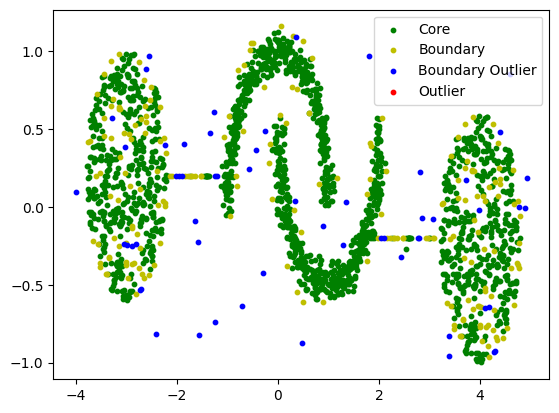

In [12]:
eps = 0.1
minpt = 5
core, bound, bound_outlr, outlr = core_bound_outlr(eps , minpt , X)
plt.scatter(X[core][:,0], X[core][:,1], c='g', s=10)
plt.scatter(X[bound][:,0], X[bound][:,1], c='y', s=10)
plt.scatter(X[bound_outlr][:,0], X[bound_outlr][:,1], c='b', s=10)
plt.scatter(X[outlr][:,0], X[outlr][:,1], c='r', s=10)
plt.legend(['Core', 'Boundary', 'Boundary Outlier', 'Outlier'])

### Clustering with DBSCAN

In [13]:
class DBSCAN:
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples
        self.labels_ = None
    
    def _get_neighbors(self, X, index):
        neighbors = []
        for i, point in enumerate(X):
            if np.linalg.norm(point - X[index]) <= self.eps:
                neighbors.append(i)
        return neighbors
    
    def _expand_cluster(self, X, index, neighbors, cluster_label):
        self.labels_[index] = cluster_label
        i = 0
        while i < len(neighbors):
            current_point_index = neighbors[i]
            if self.labels_[current_point_index] == -1:
                self.labels_[current_point_index] = cluster_label
                new_neighbors = self._get_neighbors(X, current_point_index)
                if len(new_neighbors) >= self.min_samples:
                    neighbors.extend(new_neighbors)
            i += 1
    
    def fit(self, X):
        self.labels_ = np.full(X.shape[0], -1)
        cluster_label = 0
        
        for i in range(X.shape[0]):
            if self.labels_[i] != -1:
                continue
            
            neighbors = self._get_neighbors(X, i)
            if len(neighbors) < self.min_samples:
                self.labels_[i] = -1
            else:
                cluster_label += 1
                self._expand_cluster(X, i, neighbors, cluster_label)

In [28]:
dbscan = DBSCAN(eps=0.15, min_samples=5)
dbscan.fit(X)

In [29]:
print('Cluster Labels:', dbscan.labels_)

Cluster Labels: [1 2 3 ... 3 1 3]


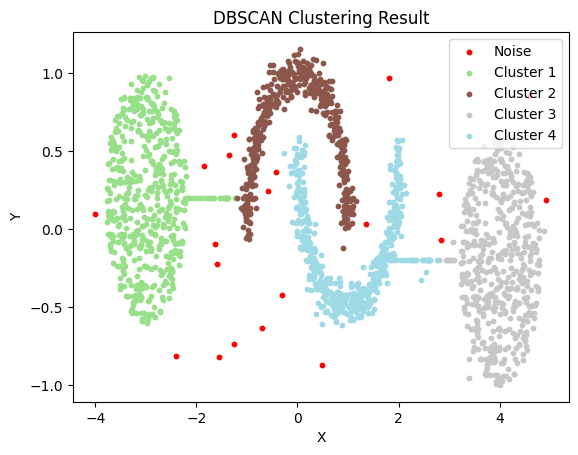

In [31]:
unique_labels = np.unique(dbscan.labels_)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

for i, label in enumerate(unique_labels):
    if label == -1:
        noise_mask = (dbscan.labels_ == label)
        plt.scatter(X[noise_mask][:, 0], X[noise_mask][:, 1], color='red', label='Noise', s=10)
    else:
        cluster_mask = (dbscan.labels_ == label)
        plt.scatter(X[cluster_mask][:, 0], X[cluster_mask][:, 1], color=colors[i], label=f'Cluster {label}', s=10)

plt.legend()
plt.title('DBSCAN Clustering Result')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()